In [1]:
from IPython.core import display
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import os

#If you are running on a server, launch xvfb to record game videos
#Please make sure you have xvfb installed
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

С теорией могут помочь эти слайды: http://rail.eecs.berkeley.edu/deeprlcourse-fa17/f17docs/lecture_5_actor_critic_pdf.pdf

А могут и не помочь.

### Мастерами кунг-фу не рождаются

Сегодня мы будем играть в Atari [KungFuMaster](https://gym.openai.com/envs/KungFuMaster-v0/), на этот раз используя рекуррентные сетки.

![kung-fu-master](https://lh3.googleusercontent.com/fzmeaDZPcTJqlrdA_NMhXOFkafTiM5JnBxUkYdgH_FlAjoCVWYmGbxia16MwnIpu1g=w412-h220-rw)

Эта игра уже намного сложнее удержания палки в вертикальном положении. Состояние — это RGB картинка монитора (трёхмерный массив размера 210x160x3), а на выбор у вас есть целых 14 действий — разные перемещения, удары, прыжки и прочее.

In [2]:
# убедитесь, что atari_util.py находится в той же директории,
# что и эта тетрадка, а также поставьте atari-py:
!pip install atari-py

In [3]:
import gym
from atari_util import PreprocessAtari

def make_env():
    env = gym.make("KungFuMasterDeterministic-v0")
    # размерность картинки слишком большая: 
    # давайте обрежем её и перегоним в чб:
    env = PreprocessAtari(env, height=42, width=42,
                          crop = lambda img: img[60:-30, 15:],
                          color=False, n_frames=1)
    return env

env = make_env()

obs_shape = env.observation_space.shape
n_actions = env.action_space.n

print("Observation shape:", obs_shape)
print("Num actions:", n_actions)
print("Action names:", env.env.env.get_action_meanings())

Observation shape: (1, 42, 42)
Num actions: 14
Action names: ['NOOP', 'UP', 'RIGHT', 'LEFT', 'DOWN', 'DOWNRIGHT', 'DOWNLEFT', 'RIGHTFIRE', 'LEFTFIRE', 'DOWNFIRE', 'UPRIGHTFIRE', 'UPLEFTFIRE', 'DOWNRIGHTFIRE', 'DOWNLEFTFIRE']


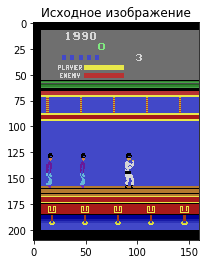

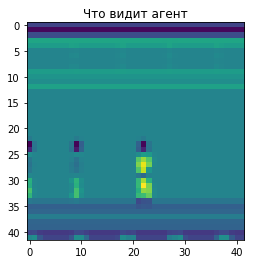

In [4]:
s = env.reset()
for _ in range(100):
    s, _, _, _ = env.step(env.action_space.sample())

plt.title('Исходное изображение')
plt.imshow(env.render('rgb_array'))
plt.show()

plt.title('Что видит агент')
plt.imshow(s.reshape([42,42]))
plt.show()

### Частично-наблюдаемые MDP

Наша игра — это на самом деле POMDP: агент знает тайминги, когда враги спавнятся и двигаются, но понять это по одной картинке он не может — ему нужна какая-то память для этого.

Нам нужна какая-то сеть, которая использует память рекуррентной сети. Например, такая:

<img src='https://github.com/yandexdataschool/Practical_RL/blob/spring19/week08_pomdp/img1.jpg?raw=true' width='500px'> 

In [5]:
import torch
import torch.nn as nn

# [batch, channel, w, h] -> [batch, units]
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [6]:
class SimpleRecurrentAgent(nn.Module):
    def __init__(self, obs_shape, n_actions, reuse=False):
        super().__init__()
        
        self.conv0 = nn.Conv2d(1, 32, kernel_size=(3,3), stride=(2,2))
        self.conv1 = nn.Conv2d(32, 32, kernel_size=(3,3), stride=(2,2))
        self.conv2 = nn.Conv2d(32, 32, kernel_size=(3,3), stride=(2,2))
        self.flatten = Flatten()

        self.hid = nn.Linear(512, 128)
        self.rnn = nn.LSTMCell(128, 128)

        self.logits = nn.Linear(128, n_actions)
        self.state_value = nn.Linear(128, 1)
        
        
    def forward(self, prev_state, obs_t):
        """
        Принимает предыдущее состояние (память) и наблюдени,
        возвращает следующее состояние и пару из политики (actor) и оценки состояния (critic) 
        """
        obs = self.flatten(self.conv2(self.conv1(self.conv0(obs_t))))
        
        
        new_state = self.rnn(self.hid(obs), prev_state)
        logits = self.logits(new_state[0])
        state_value = self.state_value(new_state[0])
        
        return new_state, (logits, state_value)
    
    def get_initial_state(self, batch_size):
        """Возвращает память агента в начале игры."""
        return torch.zeros((batch_size, 128)), torch.zeros((batch_size, 128))
    
    def sample_actions(self, agent_outputs):
        """Делает случайное действие, в соответствие с предсказанными вероятностями."""
        logits, state_values = agent_outputs
        probs = torch.softmax(logits, dim=-1)
        return torch.multinomial(probs, 1)[:, 0].data.numpy()
    
    def step(self, prev_state, obs_t):
        """Подобно forward, но obs_t это не торчевый тензор."""
        obs_t = torch.tensor(np.array(obs_t), dtype=torch.float32)
        (h, c), (l, s) = self.forward(prev_state, obs_t)
        return (h.detach(), c.detach()), (l.detach(), s.detach())

In [7]:
n_parallel_games = 5
gamma = 0.99

agent = SimpleRecurrentAgent(obs_shape, n_actions)

In [8]:
state = [env.reset()]
_, (logits, value) = agent.step(agent.get_initial_state(1), state)
print("Action logits:\n", logits)
print("State values:\n", value)

Action logits:
 tensor([[ 0.0134,  0.0767,  0.0169,  0.0260,  0.0150, -0.0011, -0.0327,  0.0484,
         -0.0133,  0.0651,  0.0161,  0.0645, -0.0108,  0.0189]])
State values:
 tensor([[0.0414]])


### Let's play!

Напишем функцию, которая меряет средний reward агента:

In [9]:
def evaluate(agent, env, n_games=1):
    """Играет игру от начала до конца и возвращает награды на каждом шаге."""

    game_rewards = []
    for _ in range(n_games):
        observation = env.reset()
        prev_memories = agent.get_initial_state(1)

        total_reward = 0
        while True:
            new_memories, readouts = agent.step(prev_memories, observation[None, ...])
            action = agent.sample_actions(readouts)

            observation, reward, done, info = env.step(action)

            total_reward += reward
            prev_memories = new_memories
            if done: break
                
        game_rewards.append(total_reward)
    return game_rewards

In [11]:
env_monitor = gym.wrappers.Monitor(env, directory="kungfu_videos", force=True)
rw = evaluate(agent, env_monitor, n_games=3,)
env_monitor.close()
print(rw)

[200.0, 500.0, 300.0]


In [12]:
# видосик
from IPython.display import HTML
import os

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./kungfu_videos/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./kungfu_videos/"+video_names[-1]))

### Параллельные игры

Введем EnvPool — это такая абстракция для управления множественными средами:

![](https://github.com/yandexdataschool/Practical_RL/blob/spring19/week08_pomdp/img2.jpg?raw=true)

In [13]:
from env_pool import EnvPool
pool = EnvPool(agent, make_env, n_parallel_games)

![](https://github.com/yandexdataschool/Practical_RL/blob/spring19/week08_pomdp/img3.jpg?raw=true)

*Роллаут* это просто последовательность наблюдений, действий и наград, которые произошли последовательно друг за другом. Обратите внимание, что это не то же самое, что сессия:

* Первое состояние не обязательно начальное для среды.
* Последнее состояние не обязательно терминальное.
* По соображениям эффективности, мы будем сэмплировать несколько параллельных роллаутов одновременно.

In [14]:
# сделать 10 шагов в каждой из n_parallel_games игр
rollout_obs, rollout_actions, rollout_rewards, rollout_mask = pool.interact(10)

In [15]:
print("Actions shape:", rollout_actions.shape)
print("Rewards shape:", rollout_rewards.shape)
print("Mask shape:", rollout_mask.shape)
print("Observations shape: ",rollout_obs.shape)

Actions shape: (5, 10)
Rewards shape: (5, 10)
Mask shape: (5, 10)
Observations shape:  (5, 10, 1, 42, 42)


# Виды RL-я

Value-based:
* Оценивают value состояния — какая там ожидаемая награда
* Политики нет, точнее она неявная — идём туда, где больше value. При обучении пользуемся $\epsilon$-greedy.

Policy-based:
* Оценивают оптимальную policy.
* Value function нет.
* (Мы делали ровно это в прошлый раз.)

Actor-critic:
* Оцениваем и policy, и value (независимо обучаем две сетки).
* Это позволяет сильно улучшить сходимость policy, потому что с помощью value-функции можно нормировать реворды из состояния, что уменьшит дисперсию градиентов.

![actor-critic](https://cs.wmich.edu/~trenary/files/cs5300/RLBook/figtmp34.png)

# Функция потерь

Наш лосс будет состоять из трёх компонент:

* **Policy loss:**
 $$ \hat J = {1 \over T} \cdot \sum_t { \log \pi(a_t | s_t) } \cdot A_{const}(s,a) $$
  * Напоминание: сама по себе эта функция не имеет смысла, и была выведена так, что
  * $ \nabla \hat J = {1 \over N} \cdot \sum_t { \nabla \log \pi(a_t | s_t) } \cdot A(s,a) \approx \nabla E_{s, a \sim \pi} R(s,a) $
  * То есть если мы максимизируем (не перепутайте тут знак) $\hat J$ градиентным спуском, то мы максимизируем ожидаемый ревард.


* **Value loss:**
  $$ L_{td} = {1 \over T} \cdot \sum_t { [r + \gamma \cdot V_{const}(s_{t+1}) - V(s_t)] ^ 2 }$$
  * Если мы будем минимизировать его, то $V(s)$ сойдётся к $V_\pi(s) = E_{a \sim \pi(a | s)} R(s,a) $


* **Энтропийная регуляризация** — вы это уже видели:
  $$ H = - {1 \over T} \sum_t \sum_a {\pi(a|s_t) \cdot \log \pi (a|s_t)}$$
  * Если максимизировать энтропию, то агент не захочет предсказывать нулевые вероятности для действий (a.k.a. exploration)
  
  
Так что мы будем оптимизировать какую-то линейную комбинацию $L_{td}$, $- \hat J$ и $-H$

**Кстати:** раз мы при обучении рассматриваем роллауты на $T$ последовательных шагов, то мы можем бесплатно использовать более точные формулы для $A(s_t, a_t)$:
  * Последний шаг: $A(s_t,a_t) = r(s_t, a_t) + \gamma \cdot V(s_{t+1}) - V(s) $
  * Предпоследний шаг: $A(s_t,a_t) = r(s_t, a_t) + \gamma \cdot r(s_{t+1}, a_{t+1}) + \gamma ^ 2 \cdot V(s_{t+2}) - V(s) $
  * ...И так далее. Так агент обучается намного быстрее, потому что он меньше зависит от шумной оценки $V$ и больше на сами награды.
  * По этой причине хорошей идеей будет увеличить rollout_len (до >=20). Ещё его лучше увеличивать с течением времени, но не обязательно.

In [16]:
def to_one_hot(y, n_dims=None):
    y_tensor = torch.tensor(y, dtype=torch.int64).view(-1, 1)
    n_dims = n_dims if n_dims is not None else int(torch.max(y_tensor)) + 1
    y_one_hot = torch.zeros(y_tensor.size()[0], n_dims).scatter_(1, y_tensor, 1)
    return y_one_hot

In [ ]:
opt = torch.optim.Adam(agent.parameters(), lr=1e-5)

def train_on_rollout(states, actions, rewards, is_not_done, prev_memory_states, gamma = 0.99):
    """
    Берет роллаут -- последовательность состояний, действий и наград, полученных из generate_session.
    Обновляет веса агента через policy gradient.
    Менять параметры Adam-а не рекомендуется.
    """
    
    # сконвертируем всё в torch.tensor
    states = torch.tensor(np.array(states), dtype=torch.float32)   # [batch_size, time, c, h, w]
    actions = torch.tensor(np.array(actions), dtype=torch.int64)   # [batch_size, time]
    rewards = torch.tensor(np.array(rewards), dtype=torch.float32) # [batch_size, time]
    is_not_done = torch.tensor(is_not_done.astype('float32'), dtype=torch.float32)  # [batch_size, time]
    rollout_length = rewards.shape[1] - 1

    # теперь нужно посчитать логиты, вероятности и лог-вероятности
    # больше для лосса нам ничего не нужно от модели
    
    memory = [m.detach() for m in prev_memory_states]
    
    logits = []
    state_values = []
    for t in range(rewards.shape[1]):
        obs_t = states[:, t]
        
        # вычислите моделью logits_t и values_t.
        # и зааппендьте их к спискам logits и state_values
        
        memory, (logits_t, values_t) = agent(memory, obs_t)
        
        logits.append(logits_t)
        state_values.append(values_t)
        
    logits = torch.stack(logits, dim=1)
    state_values = torch.stack(state_values, dim=1)
    probas = torch.softmax(logits, dim=2)
    logprobas = torch.log_softmax(logits, dim=2)
        
    # выбираем лог-вероятности для реальных действий -- log pi(a_i|s_i)
    actions_one_hot = to_one_hot(actions, n_actions).view(
        actions.shape[0], actions.shape[1], n_actions)
    logprobas_for_actions = torch.sum(logprobas * actions_one_hot, dim = -1)
    
    # Теперь посчитайте две основные компоненты лосса:
    # 1) Policy gradient
    # Примечание: не забываейте делать .detach() для advantage.
    # Ещё лучше использовать mean, а не sum, чтобы lr не масштабировать.
    # Можно исползовать тут циклы, если хотите.
    J_hat = 0  # посчитаем ниже
    
    # 2) Temporal difference MSE
    value_loss = 0  # посчитаем ниже
    
    cumulative_returns = state_values[:, -1].detach()
    for t in reversed(range(rollout_length)):
        r_t = rewards[:, t]                        # текущие reward-ы
        V_t = state_values[:, t]                   # value текущих состоияний
        V_next = state_values[:, t + 1].detach()   # value следующих состояний
        logpi_a_s_t = logprobas_for_actions[:, t]  # вероятности сделать нужное действие
        
        # G_t = r_t + gamma * G_{t+1}, как в прошлый раз на reinforce
        cumulative_returns = G_t = r_t + gamma * cumulative_returns
        
        # Посчитайте MSE для V(s)
        value_loss += # ...
        
        # посчитайте advantage A(s_t, a_t), используя cumulative returns и V(s_t) в качестве бейзлайна
        advantage = # ...
        advantage = advantage.detach()
        
        # посчитаем весь policy loss (-J_hat).
        J_hat += <YOUR CODE>
    
    entropy_reg = # compute entropy regularizer
    
    # усредним всё это дело с какими-то весами
    loss = -J_hat / rollout_length +\
           value_loss / rollout_length +\
           -0.01 * entropy_reg
    
    # сделайте шаг против градиента
    # ...
    
    return loss.data.numpy()

In [ ]:
# проверим работу
memory = list(pool.prev_memory_states)
rollout_obs, rollout_actions, rollout_rewards, rollout_mask = pool.interact(10)

train_on_rollout(rollout_obs, rollout_actions, rollout_rewards, rollout_mask, memory)

# Обучение

In [ ]:
from IPython.display import clear_output
from tqdm import trange
from pandas import DataFrame
moving_average = lambda x, **kw: DataFrame({'x':np.asarray(x)}).x.ewm(**kw).mean().values

rewards_history = []

In [ ]:
for i in trange(15000):  
    
    memory = list(pool.prev_memory_states)
    rollout_obs, rollout_actions, rollout_rewards, rollout_mask = pool.interact(10)
    train_on_rollout(rollout_obs, rollout_actions, rollout_rewards, rollout_mask, memory)    
    
    if i % 100 == 0: 
        rewards_history.append(np.mean(evaluate(agent, env, n_games=1)))
        clear_output(True)
        plt.plot(rewards_history, label='rewards')
        plt.plot(moving_average(np.array(rewards_history),span=10), label='rewards ewma@10')
        plt.legend()
        plt.show()
        if rewards_history[-1] >= 10000:
            print("Yellow belt awarded")
            break

Агент сейчас заперт в бесконечном цикле жестокости и насилий.

### Дебаг

Награды за сессию должны в целом идти в верх, но это нормально, если они будут колебаться (очень сильно). Так же нормально, что агент ничего солидного не выучит после 10к первых итераций. Что-то не так идет только тогда, реворд нулевой и не поднимается спустя 2-3 эвалов подряд.

Мы используем policy-based метод, и тут полезно смотреть на энтропию политики (та штука, которую мы использовали как регуляризацию). Если она становится слишком мала ($< 0.1$) до того момента, когда ваш агент получит желтый пояс, то что-то идет не так.

Если что-то не так, то проверьте в первую очередь следующее:
* Какой-то баг в энтропии: $ - \sum p(a_i) \cdot log p(a_i) $
* Сеть слишком быстро сходится к чему-то неоптимальному. Увеличьте коэффициент регуляризации.
* Взрывающиеся градиенты — обрежьте градиенты (`gradient_clip`) и, возможно, используйте нейронку поменьше.

При дебаге полезно запустить `logits, values = agent.step(batch_states)` и глазами посмотреть на логиты и value: возможно, там будут какие-нибудь NaN-ы, безумно большие числа или нули. Отловите этот момент как только это случилось и попытайтесь понять, что пошло не так.

### Видосик

In [ ]:
env_monitor = gym.wrappers.Monitor(env, directory="kungfu_videos", force=True)
final_rewards = evaluate(agent, env_monitor, n_games=20,)
env_monitor.close()
print("Final mean reward", np.mean(final_rewards))

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./kungfu_videos/")))
HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./kungfu_videos/"+video_names[-1]))  # убедитесь, что файл правильный